#Load Libraries

In [61]:
!pip install import-ipynb --quiet

In [62]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

Helper

In [63]:
def set_axes_equal_3d(ax):
    """
    Equal scaling for 3D axes (so the helix doesn't look distorted).
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])


def signedAngle(u=None, v=None, n=None):
    w = np.cross(u, v)
    angle = np.arctan2(np.linalg.norm(w), np.dot(u, v))
    if (np.dot(n, w) < 0):
        angle = - angle
    return angle

def rotateAxisAngle(v=None, z=None, theta=None):
    if (theta == 0):
        vNew = v
    else:
        c = np.cos(theta)
        s = np.sin(theta)
        vNew = c * v + s * np.cross(z, v) + np.dot(z, v) * (1.0 - c) * z
    return vNew

def parallel_transport(u=None, t1=None, t2=None):
    b = np.cross(t1, t2)
    if (np.linalg.norm(b) == 0):
        d = u
    else:
        b = b / np.linalg.norm(b)
        b = b - np.dot(b, t1) * t1
        b = b / np.linalg.norm(b)
        b = b - np.dot(b, t2) * t2
        b = b / np.linalg.norm(b)
        n1 = np.cross(t1, b)
        n2 = np.cross(t2, b)
        d = np.dot(u, t1) * t2 + np.dot(u, n1) * n2 + np.dot(u, b) * b
    return d

def crossMat(a):
    A = np.matrix([[0, -a[2], a[1]],
                   [a[2], 0, -a[0]],
                   [-a[1], a[0], 0]])
    return A


Reference twist / curvature

In [64]:
def computeReferenceTwist(a1e, a1f, t1, t2, refTwist=None):
    if refTwist is None:
        refTwist = 0
    P_a1e = parallel_transport(a1e, t1, t2)
    P_a1e_t = rotateAxisAngle(P_a1e, t2, refTwist)
    refTwist = refTwist + signedAngle(P_a1e_t, a1f, t2)
    return refTwist

def getRefTwist(a1, tangent, refTwist=None):
    ne = a1.shape[0]
    nv = ne + 1
    if refTwist is None:
        refTwist = np.zeros(nv)
    for c in np.arange(1, ne):
        a1e = a1[c-1, 0:3]
        a1f = a1[c,   0:3]
        t1  = tangent[c-1, 0:3]
        t2  = tangent[c,   0:3]
        refTwist[c] = computeReferenceTwist(a1e, a1f, t1, t2, refTwist[c])
    return refTwist

def computekappa(node0, node1, node2, m1e, m2e, m1f, m2f):
    t0 = (node1 - node0) / np.linalg.norm(node1 - node0)
    t1 = (node2 - node1) / np.linalg.norm(node2 - node1)

    kb = 2.0 * np.cross(t0, t1) / (1.0 + np.dot(t0, t1))
    kappa1 = 0.5 * np.dot(kb, m2e + m2f)
    kappa2 = -0.5 * np.dot(kb, m1e + m1f)

    kappa = np.zeros(2)
    kappa[0] = kappa1
    kappa[1] = kappa2
    return kappa

def getKappa(q, m1, m2):
    nv = (len(q) + 1) // 4
    ne = nv - 1
    kappa = np.zeros((nv, 2))
    for c in range(2, nv):
        node0 = q[4*c-8:4*c-5]
        node1 = q[4*c-4:4*c-1]
        node2 = q[4*c+0:4*c+3]

        m1e = m1[c-2, :].flatten()
        m2e = m2[c-2, :].flatten()
        m1f = m1[c-1, :].flatten()
        m2f = m2[c-1, :].flatten()

        kappa_local = computekappa(node0, node1, node2, m1e, m2e, m1f, m2f)
        kappa[c-1, 0] = kappa_local[0]
        kappa[c-1, 1] = kappa_local[1]
    return kappa

Frames

In [65]:
def computeTangent(q):
    nv = (len(q) + 1) // 4
    ne = nv - 1
    tangent = np.zeros((ne, 3))
    for c in range(ne):
        node0 = q[4*c:4*c+3]
        node1 = q[4*c+4:4*c+7]
        edge = node1 - node0
        tangent[c, :] = edge / np.linalg.norm(edge)
    return tangent

def computeMaterialDirectors(a1, a2, theta):
    ne = len(theta)
    m1 = np.zeros_like(a1)
    m2 = np.zeros_like(a2)
    for c in range(ne):
        cs = np.cos(theta[c])
        sn = np.sin(theta[c])
        m1[c, :] = cs * a1[c, :] + sn * a2[c, :]
        m2[c, :] = -sn * a1[c, :] + cs * a2[c, :]
    return m1, m2

def computeSpaceParallel(u1_first, q):
    nv = (len(q) + 1) // 4
    ne = nv - 1

    tangent = computeTangent(q)
    u1 = np.zeros((ne, 3))
    u2 = np.zeros((ne, 3))

    u1_first = u1_first / np.linalg.norm(u1_first)

    u1[0, :] = u1_first
    t0 = tangent[0, :]
    u2[0, :] = np.cross(t0, u1_first)
    u2[0, :] = u2[0, :] / np.linalg.norm(u2[0, :])

    for c in np.arange(1, ne):
        t0 = tangent[c-1, :]
        t1 = tangent[c, :]
        u1[c, :] = parallel_transport(u1[c-1, :], t0, t1)
        u1[c, :] = u1[c, :] / np.linalg.norm(u1[c, :])
        u2[c, :] = np.cross(t1, u1[c, :])
        u2[c, :] = u2[c, :] / np.linalg.norm(u2[c, :])

    return u1, u2

def computeTimeParallel(a1_old, q0, q):
    nv = (len(q) + 1) // 4
    ne = nv - 1

    tangent0 = computeTangent(q0)
    tangent = computeTangent(q)

    a1 = np.zeros((ne, 3))
    a2 = np.zeros((ne, 3))

    for c in np.arange(ne):
        t0 = tangent0[c, :]
        t1 = tangent[c, :]
        a1[c, :] = parallel_transport(a1_old[c, :], t0, t1)
        a1[c, :] = a1[c, :] - np.dot(a1[c, :], t1) * t1
        a1[c, :] = a1[c, :] / np.linalg.norm(a1[c, :])
        a2[c, :] = np.cross(t1, a1[c, :])
        a2[c, :] = a2[c, :] - np.dot(a2[c, :], t1) * t1
        a2[c, :] = a2[c, :] / np.linalg.norm(a2[c, :])
    return a1, a2



Elastic energies: stretching, bending, twisting

In [66]:
def gradEs_hessEs(node0=None, node1=None, l_k=None, EA=None):
    edge = node1 - node0
    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = -dF_unit
    dF[3:6] = dF_unit

    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 +
              1 / edgeLen * (np.outer(edge, edge)) / edgeLen**2)
    dJ = np.zeros((6, 6))
    dJ[0:3, 0:3] = M
    dJ[3:6, 3:6] = M
    dJ[0:3, 3:6] = -M
    dJ[3:6, 0:3] = -M
    return dF, dJ


def gradEb_hessEb(node0=None, node1=None, node2=None,
                  m1e=None, m2e=None, m1f=None, m2f=None,
                  kappaBar=None, l_k=None, EI1=None, EI2=None):

    if EI2 is None:
        EI2 = EI1

    gradKappa = np.zeros((11, 2))

    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))
    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d1 = (m1e + m1f) / chi
    tilde_d2 = (m2e + m2f) / chi

    kappa1 = 0.5 * np.dot(kb, m2e + m2f)
    kappa2 = -0.5 * np.dot(kb, m1e + m1f)

    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))
    Dkappa2De = 1.0 / norm_e * (-kappa2 * tilde_t - np.cross(tf, tilde_d1))
    Dkappa2Df = 1.0 / norm_f * (-kappa2 * tilde_t + np.cross(te, tilde_d1))

    gradKappa[0:3, 0] = -Dkappa1De
    gradKappa[4:7, 0] = Dkappa1De - Dkappa1Df
    gradKappa[8:11, 0] = Dkappa1Df
    gradKappa[0:3, 1] = -Dkappa2De
    gradKappa[4:7, 1] = Dkappa2De - Dkappa2Df
    gradKappa[8:11, 1] = Dkappa2Df
    gradKappa[3, 0] = -0.5 * np.dot(kb, m1e)
    gradKappa[7, 0] = -0.5 * np.dot(kb, m1f)
    gradKappa[3, 1] = -0.5 * np.dot(kb, m2e)
    gradKappa[7, 1] = -0.5 * np.dot(kb, m2f)


    DDkappa1 = np.zeros((11, 11))
    DDkappa2 = np.zeros((11, 11))

    EIMat = np.array([[EI1, 0], [0, EI2]])
    kappaVector = np.array([kappa1, kappa2])
    dkappaVector = kappaVector - kappaBar
    gradKappa_1 = gradKappa[:, 0]
    gradKappa_2 = gradKappa[:, 1]
    dE_dKappa1 = EI1 / l_k * dkappaVector[0]
    dE_dKappa2 = EI2 / l_k * dkappaVector[1]
    d2E_dKappa11 = EI1 / l_k
    d2E_dKappa22 = EI2 / l_k

    dF = dE_dKappa1 * gradKappa_1 + dE_dKappa2 * gradKappa_2

    gradKappa1_o_gradKappa1 = np.outer(gradKappa_1, gradKappa_1)
    gradKappa2_o_gradKappa2 = np.outer(gradKappa_2, gradKappa_2)
    dJ = (dE_dKappa1 * DDkappa1 + dE_dKappa2 * DDkappa2 +
          d2E_dKappa11 * gradKappa1_o_gradKappa1 +
          d2E_dKappa22 * gradKappa2_o_gradKappa2)

    return dF, dJ


def gradEt_hessEt(node0=None, node1=None, node2=None,
                  theta_e=None, theta_f=None,
                  refTwist=None, twistBar=None,
                  l_k=None, GJ=None):

    gradTwist = np.zeros(11)
    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    gradTwist[0:3] = -0.5 / norm_e * kb
    gradTwist[8:11] = 0.5 / norm_f * kb
    gradTwist[4:7] = -(gradTwist[0:3] + gradTwist[8:11])
    gradTwist[3] = -1
    gradTwist[7] = 1

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi


    DDtwist = np.zeros((11, 11))

    integratedTwist = theta_f - theta_e + refTwist - twistBar
    dE_dTau = GJ / l_k * integratedTwist
    d2E_dTau2 = GJ / l_k

    dF = dE_dTau * gradTwist
    gradTwist_o_gradTwist = np.outer(gradTwist, gradTwist)
    dJ = dE_dTau * DDtwist + d2E_dTau2 * gradTwist_o_gradTwist
    return dF, dJ

In [67]:
def set_axes_equal_3d(ax):
    """
    Equal scaling for 3D axes (so the helix doesn't look distorted).
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])


Assemble forces

In [68]:
def getFs(q, EA, refLen):
    ndof = len(q)
    nv = (ndof + 1) // 4
    ne = nv - 1

    Fs = np.zeros(ndof)
    Js = np.zeros((ndof, ndof))

    for c in range(ne):
        xa = q[4*c:4*c+3]
        xb = q[4*c+4:4*c+7]
        ind = np.array([4*c, 4*c+1, 4*c+2,
                        4*c+4, 4*c+5, 4*c+6])
        dL = refLen[c]
        dF, dJ = gradEs_hessEs(xa, xb, dL, EA)
        Fs[ind] -= dF
        Js[np.ix_(ind, ind)] -= dJ

    return Fs, Js

def getFb(q, m1, m2, kappaBar, EI, voronoiRefLen):
    ndof = len(q)
    nv = (ndof + 1) // 4
    ne = nv - 1

    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))

    for c in range(1, ne):
        node0 = q[4*(c-1):4*(c-1)+3]
        node1 = q[4*c:4*c+3]
        node2 = q[4*(c+1):4*(c+1)+3]

        m1e = m1[c-1, 0:3]
        m2e = m2[c-1, 0:3]
        m1f = m1[c,   0:3]
        m2f = m2[c,   0:3]

        dL = voronoiRefLen[c]
        curvature0 = kappaBar[c, 0:2]

        dF, dJ = gradEb_hessEb(node0, node1, node2,
                               m1e, m2e, m1f, m2f,
                               curvature0, dL, EI)
        ind = np.array([4*c-4, 4*c-3, 4*c-2, 4*c-1,
                        4*c,   4*c+1, 4*c+2, 4*c+3,
                        4*c+4, 4*c+5, 4*c+6])

        Fb[ind] -= dF
        Jb[np.ix_(ind, ind)] -= dJ

    return Fb, Jb

def getFt(q, refTwist, twistBar, GJ, voronoiRefLen):
    ndof = len(q)
    nv = (ndof + 1) // 4
    ne = nv - 1

    Ft = np.zeros(ndof)
    Jt = np.zeros((ndof, ndof))

    for c in range(1, ne):
        node0 = q[4*(c-1):4*(c-1)+3]
        node1 = q[4*c:4*c+3]
        node2 = q[4*(c+1):4*(c+1)+3]
        theta_e = q[4*c-1]
        theta_f = q[4*c+3]

        dL = voronoiRefLen[c]

        dF, dJ = gradEt_hessEt(node0, node1, node2,
                               theta_e, theta_f,
                               refTwist[c], twistBar[c],
                               dL, GJ)
        ind = np.array([4*c-4, 4*c-3, 4*c-2, 4*c-1,
                        4*c,   4*c+1, 4*c+2, 4*c+3,
                        4*c+4, 4*c+5, 4*c+6])

        Ft[ind] -= dF
        Jt[np.ix_(ind, ind)] -= dJ

    return Ft, Jt

Newton solve for one time step

In [69]:
def objfun(qOld, uOld, a1_old, a2_old,
           freeIndex,
           dt, tol,
           refTwist,
           massVector, massMatrix,
           EA, refLen,
           EI, GJ, voronoiRefLen,
           kappaBar, twistBar,
           Fg):

    q_new = qOld.copy()
    error = 10 * tol
    max_iter = 30
    iter_count = 0

    while error > tol and iter_count < max_iter:
        # reference frame
        a1_new, a2_new = computeTimeParallel(a1_old, qOld, q_new)
        tangent = computeTangent(q_new)
        refTwist_new = getRefTwist(a1_new, tangent, refTwist)

        theta = q_new[3::4]
        m1, m2 = computeMaterialDirectors(a1_new, a2_new, theta)

        Fs, Js = getFs(q_new, EA, refLen)
        Fb, Jb = getFb(q_new, m1, m2, kappaBar, EI, voronoiRefLen)
        Ft, Jt = getFt(q_new, refTwist_new, twistBar, GJ, voronoiRefLen)

        Forces = Fs + Fb + Ft + Fg
        JForces = Js + Jb + Jt

        f = massVector / dt * ((q_new - qOld) / dt - uOld) - Forces
        J = massMatrix / dt**2 - JForces

        f_free = f[freeIndex]
        J_free = J[np.ix_(freeIndex, freeIndex)]

        dq_free = np.linalg.solve(J_free, f_free)
        q_new[freeIndex] -= dq_free

        error = np.max(np.abs(dq_free))
        iter_count += 1

    uNew = (q_new - qOld) / dt
    return q_new, uNew, a1_new, a2_new

Geometry and material setup

In [70]:
nv = 50
ne = nv - 1
ndof = 3*nv + ne

r0 = 0.001  # wire radius (d = 0.002)
D = 0.04
pitch = 2 * r0
N = 5
a = D/2.0
b = pitch / (2.0 * np.pi)
T = 2.0 * np.pi * N
L = T * np.sqrt(a**2 + b**2)
axial_l = N * pitch

print("\nPart 1: Single Load Level")
print("="*50)
print('Helix diameter = ', D)
print('Pitch = ', pitch)
print('N = ', N)
print('Arc length = ', L)
print('axial_l = ', axial_l)

nodes = np.zeros((nv, 3))
for c in range(nv):
    t = c * T / (nv - 1.0)
    nodes[c, 0] = a * np.cos(t)
    nodes[c, 1] = a * np.sin(t)
    nodes[c, 2] = -b * t

Y = 10e6
nu = 0.5
G = Y / (2.0 * (1.0 + nu))

EA = Y * np.pi * r0**2
EI = Y * np.pi * r0**4 / 4.0
GJ = G * np.pi * r0**4 / 2.0

totalTime = 5.0
dt = 0.1

# Tolerance in terms of |dq|
tol = (L / nv) * 1e-6

rho = 1000.0
totalM = L * np.pi * r0**2 * rho
dm = totalM / ne

massVector = np.zeros(ndof)
for c in range(nv):
    ind = [4*c, 4*c+1, 4*c+2]
    if c == 0 or c == nv-1:
        massVector[ind] = dm/2.0
    else:
        massVector[ind] = dm

for c in range(ne):
    massVector[4*c+3] = 0.5 * dm * r0**2

massMatrix = np.diag(massVector)

F_end = EI / L**2
vectorLoad = np.array([0.0, 0.0, -F_end])
Fg = np.zeros(ndof)
c_last = nv-1
ind_last = [4*c_last, 4*c_last+1, 4*c_last+2]
Fg[ind_last] += vectorLoad

qOld = np.zeros(ndof)
for c in range(nv):
    ind = [4*c, 4*c+1, 4*c+2]
    qOld[ind] = nodes[c, :]

uOld = np.zeros_like(qOld)

refLen = np.zeros(ne)
for c in range(ne):
    refLen[c] = np.linalg.norm(nodes[c+1, :] - nodes[c, :])

voronoiRefLen = np.zeros(nv)
for c in range(nv):
    if c == 0:
        voronoiRefLen[c] = 0.5 * refLen[c]
    elif c == nv-1:
        voronoiRefLen[c] = 0.5 * refLen[c-1]
    else:
        voronoiRefLen[c] = 0.5 * (refLen[c-1] + refLen[c])

tangent = computeTangent(qOld)
t0 = tangent[0, :]
arb_v = np.array([0.0, 0.0, -1.0])
a1_first = np.cross(t0, arb_v)
if np.linalg.norm(a1_first) < 1e-3:
    arb_v = np.array([0.0, 1.0, 0.0])
    a1_first = np.cross(t0, arb_v)
a1_first = a1_first / np.linalg.norm(a1_first)

a1, a2 = computeSpaceParallel(a1_first, qOld)
theta = qOld[3::4]
m1, m2 = computeMaterialDirectors(a1, a2, theta)

refTwist = np.zeros(nv)
kappaBar = getKappa(qOld, m1, m2)
twistBar = np.zeros(nv)

fixedIndex = np.concatenate((np.arange(0, 7),
                             [4*(nv-1), 4*(nv-1)+1]))
freeIndex = np.setdiff1d(np.arange(ndof), fixedIndex)


Part 1: Single Load Level
Helix diameter =  0.04
Pitch =  0.002
N =  5
Arc length =  0.6283981031508404
axial_l =  0.01


Steady–state

In [75]:
def is_steady_state(endZ_history, window=50, tolerance=0.03):
    if len(endZ_history) < window:
        if len(endZ_history) == 0:
            return False, 0.0
        mean_val = np.mean(endZ_history)
        return False, mean_val

    recent = endZ_history[-window:]
    mean_val = np.mean(recent)
    max_val = np.max(recent)
    min_val = np.min(recent)

    if abs(mean_val) > 1e-10:
        relative_change = (max_val - min_val) / abs(mean_val)
    else:
        relative_change = abs(max_val - min_val)

    state = relative_change < tolerance
    return state, mean_val

Part 1: Single load level

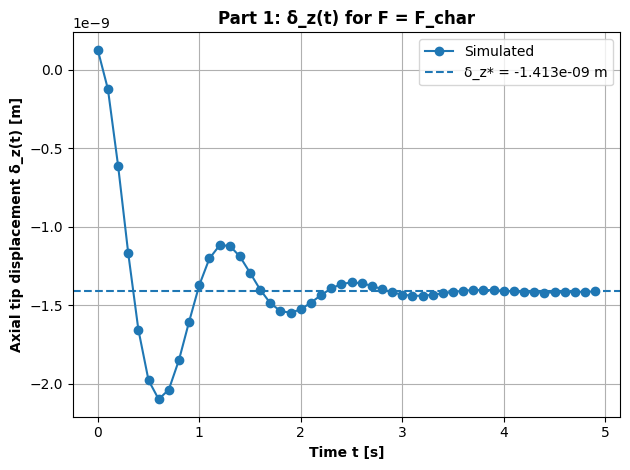

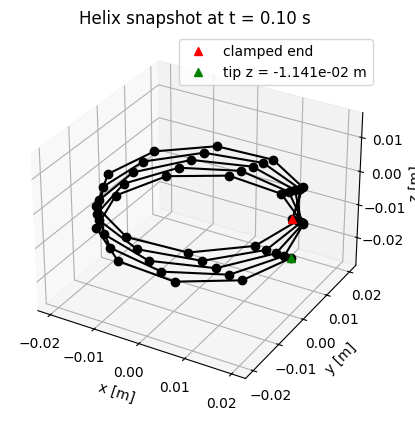

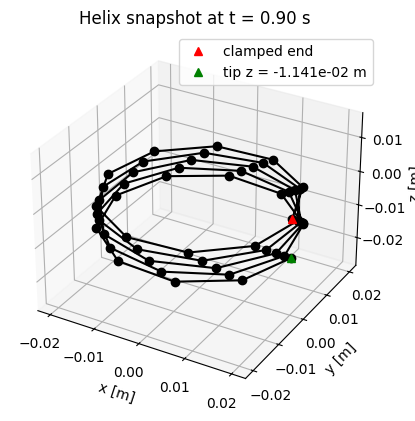

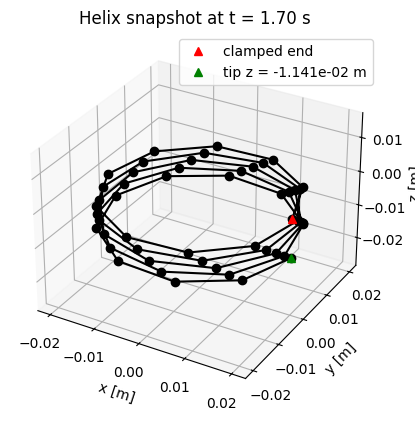

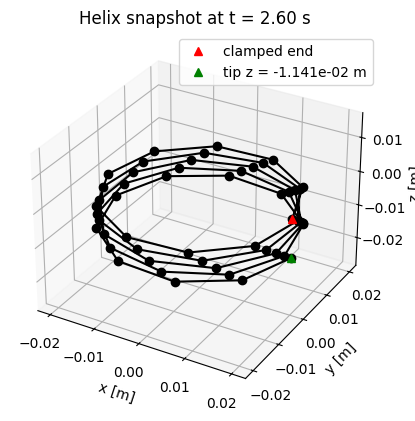

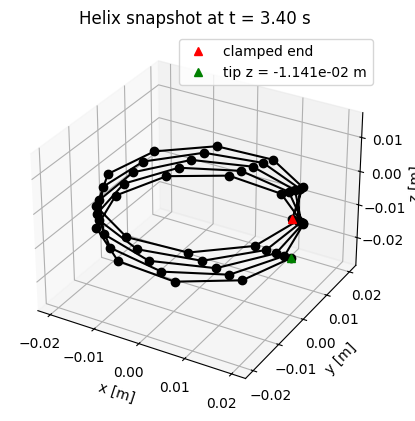

In [76]:
Nsteps = round(totalTime / dt)
ctime = 0.0
endZ_0 = qOld[-1]
endZ = np.zeros(Nsteps)
ss_value = 0.0

snapshot_times = np.linspace(0, totalTime, 7)
snapshot_indices = sorted(set(int(t/dt) for t in snapshot_times))
snapshots = []

a1_old = a1.copy()
a2_old = a2.copy()

convergence_reported = False
last_index = Nsteps
con_z = 0.0

for step in range(Nsteps):
    q_new, u_new, a1_new, a2_new = objfun(
        qOld, uOld, a1_old, a2_old,
        freeIndex, dt, tol, refTwist,
        massVector, massMatrix,
        EA, refLen,
        EI, GJ, voronoiRefLen,
        kappaBar, twistBar,
        Fg
    )
    endZ[step] = q_new[-1] - endZ_0
    steady_s, con_z = is_steady_state(endZ[:step+1])

    if steady_s and not convergence_reported:
        ss_value = con_z
        last_index = step
        convergence_reported = True

    ctime += dt
    qOld = q_new.copy()
    uOld = u_new.copy()
    a1_old = a1_new.copy()
    a2_old = a2_new.copy()

    if step in snapshot_indices:
        snapshots.append((ctime, q_new.copy()))


# Plot displacement vs time for Part 1
plt.figure()
plot_end_index = last_index + 1 if convergence_reported else Nsteps
time_array = np.arange(plot_end_index) * dt
plt.plot(time_array, endZ[:plot_end_index], 'o-', label="Simulated")

# Choose the steady-state value to plot as a horizontal line
if convergence_reported:
    steady_val = ss_value
else:
    steady_val = endZ[plot_end_index - 1]

plt.axhline(y=steady_val, linestyle="--",
            label=f"δ_z* = {steady_val:.3e} m")

plt.xlabel('Time t [s]', fontweight='bold')
plt.ylabel('Axial tip displacement δ_z(t) [m]', fontweight='bold')
plt.title('Part 1: δ_z(t) for F = F_char', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Show at least 5 helix snapshots
n_show = min(5, len(snapshots))

for i in range(n_show):
    t_snap, q_snap = snapshots[i]

    x1 = q_snap[0::4]
    x2 = q_snap[1::4]
    x3 = q_snap[2::4]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(x1, x2, x3, 'ko-')
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^', label='clamped end')
    ax.plot3D([x1[-1]], [x2[-1]], [x3[-1]], 'g^',
              label=f'tip z = {x3[-1]:.3e} m')

    ax.set_title(f'Helix snapshot at t = {t_snap:.2f} s')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    ax.legend()
    set_axes_equal(ax)
    plt.show()





Part 2: Force sweep + linear fit


Part 2: Force Sweep
Characteristic force F_char = 1.988933e-05 N

Simulation 1/7: F = 1.988933e-07 N (0.010 × F_char)
  Steady State at t = 7.000s: δ_z* = -1.447556e-05 m

Simulation 2/7: F = 6.289558e-07 N (0.032 × F_char)
  Steady State at t = 7.000s: δ_z* = -4.575213e-05 m

Simulation 3/7: F = 1.988933e-06 N (0.100 × F_char)
  Steady State at t = 6.750s: δ_z* = -1.444669e-04 m

Simulation 4/7: F = 6.289558e-06 N (0.316 × F_char)
  Steady State at t = 6.750s: δ_z* = -4.544823e-04 m

Simulation 5/7: F = 1.988933e-05 N (1.000 × F_char)
  Steady State at t = 6.750s: δ_z* = -1.413731e-03 m

Simulation 6/7: F = 6.289558e-05 N (3.162 × F_char)
  Steady State at t = 17.630s: δ_z* = -4.142158e-03 m

Simulation 7/7: F = 1.988933e-04 N (10.000 × F_char)
  Steady State at t = 15.770s: δ_z* = -1.351641e-02 m

Fitted stiffness (Part 2): k = 1.383152e-02 N/m



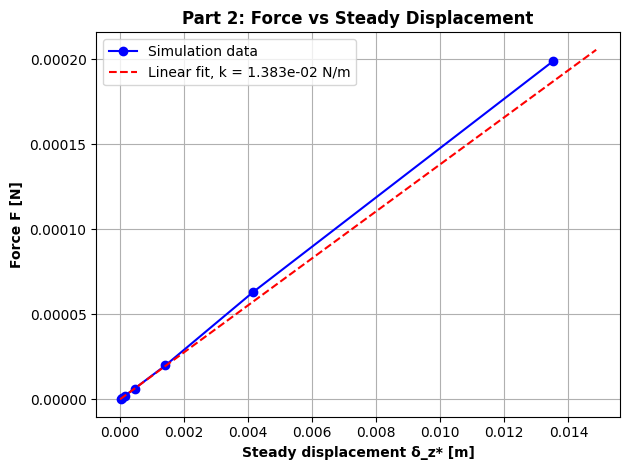

In [77]:
print("\nPart 2: Force Sweep")
print("="*50)

F_char = EI / L**2
print(f"Characteristic force F_char = {F_char:.6e} N")

dt_optimal = [0.1, 0.1, 0.05, 0.05, 0.05, 0.01, 0.005]
n_forces = 7
F_array = np.logspace(np.log10(0.01 * F_char),
                      np.log10(10 * F_char), n_forces)
delta_z_steady_array = np.zeros(n_forces)

for i_force, F_applied in enumerate(F_array):
    print(f"\nSimulation {i_force+1}/{n_forces}: F = {F_applied:.6e} N "
          f"({F_applied/F_char:.3f} × F_char)")

    dt = dt_optimal[i_force]
    totalTime = 20.0
    tol = (L / nv) * 1e-6

    nodes = np.zeros((nv, 3))
    for c in range(nv):
        t = c * T / (nv - 1.0)
        nodes[c, 0] = a * np.cos(t)
        nodes[c, 1] = a * np.sin(t)
        nodes[c, 2] = -b * t

    vectorLoad = np.array([0.0, 0.0, -F_applied])
    Fg = np.zeros(ndof)
    ind_last = [4*c_last, 4*c_last+1, 4*c_last+2]
    Fg[ind_last] += vectorLoad

    qOld = np.zeros(ndof)
    for c in range(nv):
        ind = [4*c, 4*c+1, 4*c+2]
        qOld[ind] = nodes[c, :]

    uOld = np.zeros_like(qOld)

    refLen = np.zeros(ne)
    for c in range(ne):
        refLen[c] = np.linalg.norm(nodes[c+1, :] - nodes[c, :])

    voronoiRefLen = np.zeros(nv)
    for c in range(nv):
        if c == 0:
            voronoiRefLen[c] = 0.5 * refLen[c]
        elif c == nv-1:
            voronoiRefLen[c] = 0.5 * refLen[c-1]
        else:
            voronoiRefLen[c] = 0.5 * (refLen[c-1] + refLen[c])

    tangent = computeTangent(qOld)
    t0 = tangent[0, :]
    arb_v = np.array([0.0, 0.0, -1.0])
    a1_first = np.cross(t0, arb_v)
    if np.linalg.norm(a1_first) < 1e-3:
        arb_v = np.array([0.0, 1.0, 0.0])
        a1_first = np.cross(t0, arb_v)
    a1_first = a1_first / np.linalg.norm(a1_first)

    a1, a2 = computeSpaceParallel(a1_first, qOld)
    theta = qOld[3::4]
    m1, m2 = computeMaterialDirectors(a1, a2, theta)

    refTwist = np.zeros(nv)
    kappaBar = getKappa(qOld, m1, m2)
    twistBar = np.zeros(nv)

    fixedIndex = np.concatenate((np.arange(0, 7),
                                 [4*(nv-1), 4*(nv-1)+1]))
    freeIndex = np.setdiff1d(np.arange(ndof), fixedIndex)

    Nsteps = round(totalTime / dt)
    ctime = 0.0
    endZ_0 = qOld[-1]
    endZ_history = []

    a1_old = a1.copy()
    a2_old = a2.copy()
    convergence_reported = False
    mean_z = 0.0
    steps_per_check = max(1, int(0.1 / dt))

    for step in range(Nsteps):
        q_new, u_new, a1_new, a2_new = objfun(
            qOld, uOld, a1_old, a2_old,
            freeIndex, dt, tol, refTwist,
            massVector, massMatrix,
            EA, refLen,
            EI, GJ, voronoiRefLen,
            kappaBar, twistBar,
            Fg
        )

        endZ = q_new[-1] - endZ_0
        endZ_history.append(endZ)

        if step >= steps_per_check:
            steady_s, con_z = is_steady_state(endZ_history[:step+1])
            if steady_s:
                print(f'  Steady State at t = {ctime:.3f}s: '
                      f'δ_z* = {con_z:.6e} m')
                convergence_reported = True
                mean_z = con_z
                break

        ctime += dt
        qOld = q_new.copy()
        uOld = u_new.copy()
        a1_old = a1_new.copy()
        a2_old = a2_new.copy()

    if convergence_reported:
        delta_z_steady_array[i_force] = mean_z
    else:
        delta_z_steady_array[i_force] = endZ_history[-1]
        print(f'  Max time reached; using last δ_z* = {endZ_history[-1]:.6e} m')

# Linear fit: F ≈ k δ_z* (small-displacement region)
delta_z_edit = np.abs(delta_z_steady_array)
n_fit = len(F_array) // 2 + 1

k_fitted = np.sum(F_array[:n_fit] * delta_z_edit[:n_fit]) / \
           np.sum(delta_z_edit[:n_fit]**2)

print(f"\nFitted stiffness (Part 2): k = {k_fitted:.6e} N/m\n")

# Plot Part 2: F vs δ_z*
plt.figure()
plt.plot(delta_z_edit, F_array, 'bo-', label='Simulation data')
dz_fit = np.linspace(0, max(delta_z_edit)*1.1, 100)
F_fit = k_fitted * dz_fit
plt.plot(dz_fit, F_fit, 'r--',
         label=f'Linear fit, k = {k_fitted:.3e} N/m')
plt.xlabel('Steady displacement δ_z* [m]', fontweight='bold')
plt.ylabel('Force F [N]', fontweight='bold')
plt.title('Part 2: Force vs Steady Displacement', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Homework4_Part2_Force_Displacement.pdf', dpi=300, bbox_inches='tight')
plt.show()

Part 3: Diameter sweep

Part 3: Diameter Sweep

Diameter D = 0.0100 m
  F = 3.170250e-06 N (0.010 × F_char)
    Steady at t=4.900s: δ_z* = -2.788772e-06 m
  F = 3.170250e-05 N (0.100 × F_char)
    Steady at t=4.900s: δ_z* = -2.786501e-05 m
  F = 3.170250e-04 N (1.000 × F_char)
    Steady at t=2.500s: δ_z* = -2.766450e-04 m
  Fitted stiffness for D=0.0100 m: k = 1.145879e+00 N/m

Diameter D = 0.0144 m
  F = 1.522669e-06 N (0.010 × F_char)
    Steady at t=5.100s: δ_z* = -4.334822e-06 m
  F = 1.522669e-05 N (0.100 × F_char)
    Steady at t=5.100s: δ_z* = -4.328862e-05 m
  F = 1.522669e-04 N (1.000 × F_char)
    Steady at t=2.600s: δ_z* = -4.271498e-04 m
  Fitted stiffness for D=0.0144 m: k = 3.564234e-01 N/m

Diameter D = 0.0189 m
  F = 8.911366e-07 N (0.010 × F_char)
    Steady at t=5.200s: δ_z* = -6.012134e-06 m
  F = 8.911366e-06 N (0.100 × F_char)
    Steady at t=5.200s: δ_z* = -6.001208e-05 m
  F = 8.911366e-05 N (1.000 × F_char)
    Steady at t=2.700s: δ_z* = -5.893085e-04 m
  Fitted stiffness for D=0.0189

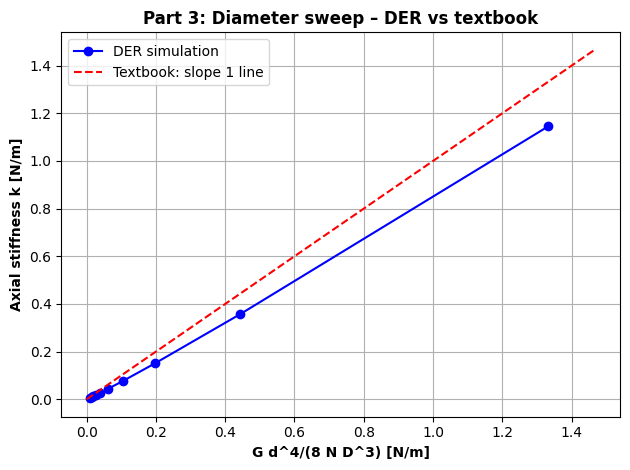

In [78]:
print("Part 3: Diameter Sweep")
print("="*50)

D_array = np.linspace(0.01, 0.05, 10)
k_fit_array = []

for D_Helix in D_array:
    print(f"\nDiameter D = {D_Helix:.4f} m")
    D = D_Helix
    a = D/2.0
    b = pitch / (2.0 * np.pi)
    T = 2.0 * np.pi * N
    L = T * np.sqrt(a**2 + b**2)
    axial_l = N * pitch

    F_char = EI / L**2
    dt_optimal = [0.1, 0.1, 0.05]
    totalM = L * np.pi * r0**2 * rho
    dm = totalM / ne

    massVector = np.zeros(ndof)
    for c in range(nv):
        ind = [4*c, 4*c+1, 4*c+2]
        if c == 0 or c == nv-1:
            massVector[ind] = dm/2.0
        else:
            massVector[ind] = dm
    for c in range(ne):
        massVector[4*c+3] = 0.5 * dm * r0**2
    massMatrix = np.diag(massVector)

    n_forces = 3
    F_array = np.logspace(np.log10(0.01*F_char),
                          np.log10(F_char),
                          n_forces)
    delta_z_steady_array = np.zeros(n_forces)

    for i_force, F_applied in enumerate(F_array):
        print(f"  F = {F_applied:.6e} N ({F_applied/F_char:.3f} × F_char)")
        dt = dt_optimal[i_force]
        totalTime = 20.0
        tol = (L / nv) * 1e-6

        nodes = np.zeros((nv, 3))
        for c in range(nv):
            t = c * T / (nv - 1.0)
            nodes[c, 0] = a * np.cos(t)
            nodes[c, 1] = a * np.sin(t)
            nodes[c, 2] = -b * t

        vectorLoad = np.array([0.0, 0.0, -F_applied])
        Fg = np.zeros(ndof)
        ind_last = [4*c_last, 4*c_last+1, 4*c_last+2]
        Fg[ind_last] += vectorLoad

        qOld = np.zeros(ndof)
        for c in range(nv):
            ind = [4*c, 4*c+1, 4*c+2]
            qOld[ind] = nodes[c, :]

        uOld = np.zeros_like(qOld)

        refLen = np.zeros(ne)
        for c in range(ne):
            refLen[c] = np.linalg.norm(nodes[c+1, :] - nodes[c, :])

        voronoiRefLen = np.zeros(nv)
        for c in range(nv):
            if c == 0:
                voronoiRefLen[c] = 0.5 * refLen[c]
            elif c == nv-1:
                voronoiRefLen[c] = 0.5 * refLen[c-1]
            else:
                voronoiRefLen[c] = 0.5 * (refLen[c-1] + refLen[c])

        tangent = computeTangent(qOld)
        t0 = tangent[0, :]
        arb_v = np.array([0.0, 0.0, -1.0])
        a1_first = np.cross(t0, arb_v)
        if np.linalg.norm(a1_first) < 1e-3:
            arb_v = np.array([0.0, 1.0, 0.0])
            a1_first = np.cross(t0, arb_v)
        a1_first = a1_first / np.linalg.norm(a1_first)

        a1, a2 = computeSpaceParallel(a1_first, qOld)
        theta = qOld[3::4]
        m1, m2 = computeMaterialDirectors(a1, a2, theta)

        refTwist = np.zeros(nv)
        kappaBar = getKappa(qOld, m1, m2)
        twistBar = np.zeros(nv)

        fixedIndex = np.concatenate((np.arange(0, 7),
                                     [4*(nv-1), 4*(nv-1)+1]))
        freeIndex = np.setdiff1d(np.arange(ndof), fixedIndex)

        Nsteps = round(totalTime / dt)
        ctime = 0.0
        endZ_0 = qOld[-1]
        endZ_history = []
        a1_old = a1.copy()
        a2_old = a2.copy()
        convergence_reported = False
        mean_z = 0.0
        steps_per_check = max(1, int(0.1/dt))

        for step in range(Nsteps):
            q_new, u_new, a1_new, a2_new = objfun(
                qOld, uOld, a1_old, a2_old,
                freeIndex, dt, tol, refTwist,
                massVector, massMatrix,
                EA, refLen,
                EI, GJ, voronoiRefLen,
                kappaBar, twistBar,
                Fg
            )

            endZ = q_new[-1] - endZ_0
            endZ_history.append(endZ)

            if step >= steps_per_check:
                steady_s, con_z = is_steady_state(endZ_history[:step+1])
                if steady_s:
                    print(f'    Steady at t={ctime:.3f}s: δ_z* = {con_z:.6e} m')
                    convergence_reported = True
                    mean_z = con_z
                    break

            ctime += dt
            qOld = q_new.copy()
            uOld = u_new.copy()
            a1_old = a1_new.copy()
            a2_old = a2_new.copy()

        if convergence_reported:
            delta_z_steady_array[i_force] = mean_z
        else:
            delta_z_steady_array[i_force] = endZ_history[-1]
            print(f'    Max time; using last δ_z* = {endZ_history[-1]:.6e} m')

    delta_z_edit = np.abs(delta_z_steady_array)
    n_fit = len(F_array)
    k_fitted = np.sum(F_array * delta_z_edit) / np.sum(delta_z_edit**2)
    print(f"  Fitted stiffness for D={D_Helix:.4f} m: k = {k_fitted:.6e} N/m")
    k_fit_array.append(k_fitted)

G = Y / (2.0 * (1.0 + nu))
x_axis = (G * (2*r0)**4) / (8 * N * D_array**3)

print("\nPART 3 RESULTS:")
print(f"{'D (m)':<12} {'k_DER (N/m)':<15} {'Gd^4/(8ND^3)':<15}")
for i in range(len(D_array)):
    print(f"{D_array[i]:<12.4f} {k_fit_array[i]:<15.6e} {x_axis[i]:<15.6e}")

plt.figure()
plt.plot(x_axis, k_fit_array, 'bo-', label='DER simulation')
x_line = np.linspace(0, max(x_axis)*1.1, 100)
y_line = x_line
plt.plot(x_line, y_line, 'r--', label='Textbook: slope 1 line')
plt.xlabel('G d^4/(8 N D^3) [N/m]', fontweight='bold')
plt.ylabel('Axial stiffness k [N/m]', fontweight='bold')
plt.title('Part 3: Diameter sweep – DER vs textbook', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
